In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
from datetime import date
import calendar

import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Sixt Data Science Lab - Test Task for Data Scientist Job Candidates

## Introduction

In this test task you will have an opportunity to demonstrate your skills of a Data Scientist from various angles - processing data, analyzing and vizalizing it, finding insights, applying predictive techniques and explaining your reasoning about it.

The task is based around a bike sharing dataset openly available at UCI Machine Learning Repository [1].

Please go through the steps below, build up the necessary code and comment on your choices.

## Part 1 - Data Loading and Environment Preparation

**Tasks:**
1. Prepare a Python 3 virtual environment (with virtualenv command). requirements.txt output of pip freeze command should be included as part of your submission.
2. Load the data from UCI Repository and put it into the same folder with the notebook. The link to it is https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset . Here is an available mirror in case the above website is down: https://data.world/uci/bike-sharing-dataset
3. We split the data into two parts. One dataset containing the last 30 days and one dataset with the rest.

In [7]:
df_day = pd.read_csv("data/dataset/day.csv", parse_dates=['dteday']).sort_values(
    by='dteday').reset_index(drop=True)

# split dataset
df_last30 = df_day.tail(30)
df = df_day.iloc[:-30, :]


## Part 2 - Data Processing and Analysis

**Tasks:**
1. Perform all needed steps to load and clean the data. Please comment the major steps of your code.
2. Visualise rentals of bikes per day.
3. Assume that each bike has exactly maximum 12 rentals per day.
    * Find the maximum number of bicycles `nmax` that was needed in any one day.
    * Find the 95%-percentile of bicycles `n95` that was needed in any one day.
5. Visualize the distribution of the covered days depending on the number of available bicycles (e.g. `nmax` bicycles would cover 100% of days, `n95` covers 95%, etc.)


**Answers / comments / reasoning:**

1. Data contains 
   1. no null value
   2. Only 4 columns with outlier % more than 1%
2. Check cell below
3. If each bike has exactly maximum 12 rentals per day
   1. Maximum bikes needed (nmax): 726
   2. 95th percentile bikes needed (n95): 632
4. Visualisation : Check below cells

In [ ]:
print("Shape of the dataset", df_day.shape, "\n")
print("Null value count", df_day.isnull().sum())

Shape of the dataset (731, 16) 

Null value count instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64
instant: 0.00% outliers
season: 0.00% outliers
yr: 0.00% outliers
mnth: 0.00% outliers
holiday: 2.85% outliers
weekday: 0.00% outliers
workingday: 0.00% outliers
weathersit: 0.00% outliers
temp: 0.00% outliers
atemp: 0.00% outliers
hum: 0.29% outliers
windspeed: 1.71% outliers
casual: 5.14% outliers
registered: 0.00% outliers
cnt: 0.00% outliers

 Outliers % above 2%


{'holiday': np.float64(2.85), 'casual': np.float64(5.14)}

In [14]:
# Outlier Detection
df = df_day.copy()

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

outlier_percentages = {}
columns_above_threshold = {}
threshold = 0

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers for this column
    col_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    total_values = df[col].notnull().sum()
    
    outlier_percentages[col] = (col_outliers / total_values) * 100
    
    if outlier_percentages[col] > threshold:
        columns_above_threshold[col] = round((col_outliers / total_values) * 100, 2)

# Display results
for col, pct in outlier_percentages.items():
    print(f"{col}: {pct:.2f}% outliers")
    
    
print("\n" ,"Outliers % above 2%")

columns_above_threshold

instant: 0.00% outliers
season: 0.00% outliers
yr: 0.00% outliers
mnth: 0.00% outliers
holiday: 2.87% outliers
weekday: 0.00% outliers
workingday: 0.00% outliers
weathersit: 0.00% outliers
temp: 0.00% outliers
atemp: 0.00% outliers
hum: 0.27% outliers
windspeed: 1.78% outliers
casual: 6.02% outliers
registered: 0.00% outliers
cnt: 0.00% outliers

 Outliers % above 2%


{'holiday': np.float64(2.87),
 'hum': np.float64(0.27),
 'windspeed': np.float64(1.78),
 'casual': np.float64(6.02)}

/var/folders/_4/kyhrjqh97571rhyj62w1kdwr0000gn/T/ipykernel_88723/1339384418.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


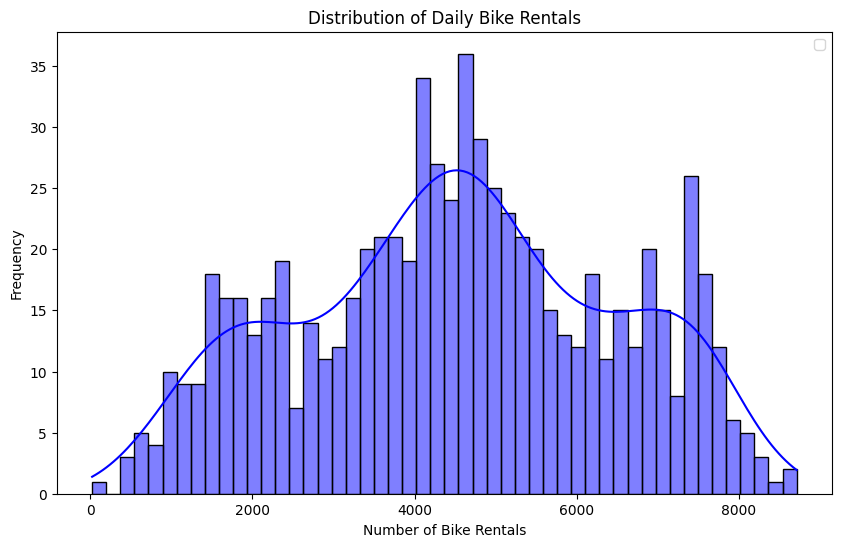

In [17]:
# Plot distribution curve
plt.figure(figsize=(10,6))
sns.histplot(df_day["cnt"], bins=50, kde=True, color='blue')  # Histogram + KDE curve
plt.title('Distribution of Daily Bike Rentals')
plt.xlabel('Number of Bike Rentals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [18]:
# Assume each bike can have max 12 rentals per day
df_day['bikes_cnt'] = round(df_day['cnt'] / 12)

# Maximum number of bicycles needed (nmax)
nmax_bike = df_day['bikes_cnt'].max()

# 95th percentile of bicycles needed (n95)
n95_bike = df_day['bikes_cnt'].quantile(0.95)

print(f"Maximum bikes needed (nmax): {nmax_bike:.0f}")
print(f"95th percentile bikes needed (n95): {n95_bike:.0f}")

Maximum bikes needed (nmax): 726
95th percentile bikes needed (n95): 632


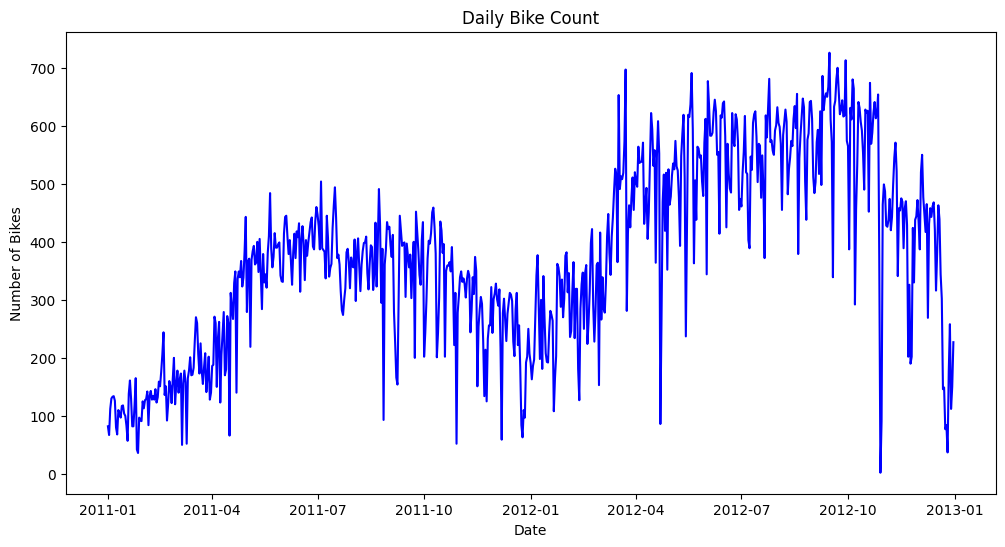

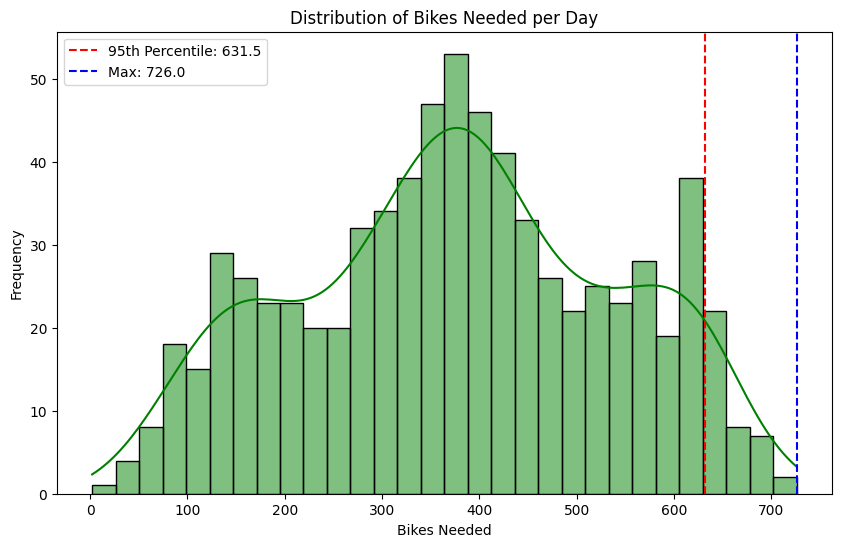

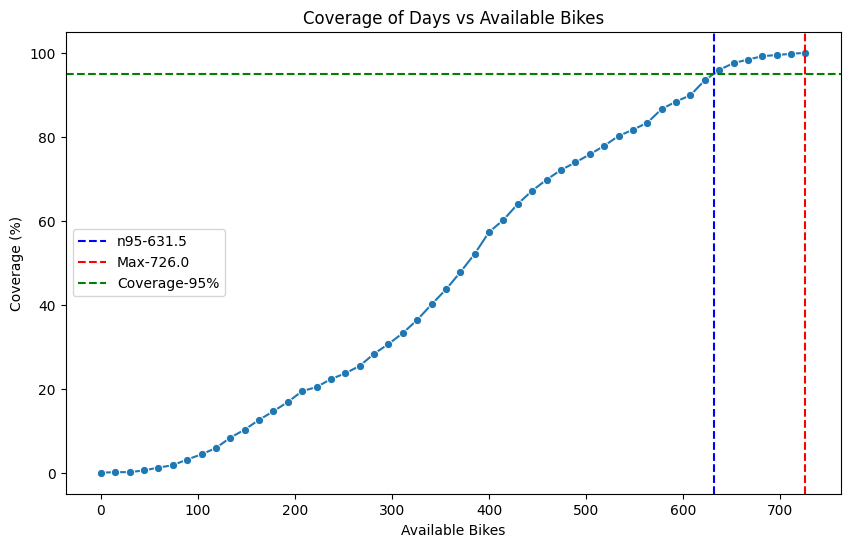

In [32]:
# -----------------------------
# 3. Visualize rentals per day
# -----------------------------
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_day['dteday'], y=df_day['bikes_cnt'].values, color='blue')
plt.title('Daily Bike Count')
plt.xlabel('Date')
plt.ylabel('Number of Bikes')
plt.show()

# -----------------------------
# 4. Distribution of bikes needed
# -----------------------------
plt.figure(figsize=(10, 6))
sns.histplot(df_day['bikes_cnt'], bins=30, kde=True, color='green')
plt.axvline(n95_bike, color='red', linestyle='--', label=f'95th Percentile: {n95_bike}')
plt.axvline(nmax_bike, color='blue', linestyle='--', label=f'Max: {nmax_bike}')
plt.title('Distribution of Bikes Needed per Day')
plt.xlabel('Bikes Needed')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# -----------------------------
# 5. Coverage curve
# -----------------------------
thresholds = np.linspace(0, nmax_bike, 50)
coverage = [(t, (df_day['bikes_cnt'] <= t).mean() * 100) for t in thresholds]
coverage_df = pd.DataFrame(coverage, columns=['Available Bikes', 'Coverage (%)'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=coverage_df, x='Available Bikes', y='Coverage (%)', marker='o')
plt.title('Coverage of Days vs Available Bikes')
plt.xlabel('Available Bikes')
plt.ylabel('Coverage (%)')
plt.axvline(n95_bike, color='blue', linestyle='--', label=f'n95-{n95_bike}')
plt.axvline(nmax_bike, color='red', linestyle='--', label=f'Max-{nmax_bike}')
plt.axhline(95, color='g', linestyle='--', label=f'Coverage-95%')
plt.legend()
plt.show()


## Part 3 - Building prediction models

**Tasks:**
1. Define a test metric for predicting the daily demand for bike sharing, which you would like to use to measure the accuracy of the constructed models, and explain your choice.
2. Build a demand prediction model with Random Forest, preferably making use of following python libraries: scikit-learn. 
3. Report the value of the chosen test metric on the provided data. 

In [ ]:
# TODO: your code comes here

**Answers / comments / reasoning:**

### 1. Problem Statement

#### Case 1: Binary Classification Task
Develop a binary classification model that, for a given bike sharing station, predicts whether the next day's demand will exceed a predefined profit-maximizing threshold

Test metric: 
    1. False Negative (FN) - Cost of Lost Revenue. The model predicts Low Demand (0), but the actual demand is High
    2. False Positive (FP) - Cost of Wasted Operations. The model predicts High Demand (1), but the actual demand is Low (0).

#### Case 2: Regression Task
To maximize the daily operational efficiency and profitability of the bike-sharing system at a specific station by accurately predicting the exact number of daily rentals. This precise forecast will allow operations teams to optimally manage bike inventory and logistical resources, minimizing both service unavailability and wasted rebalancing costs.

Test metric: Root mean squared error because when the errors follow a normal distribution, using RMSE (or MSE) gives the best results because it matches the way normal data behaves. Since there are no outliers, we don’t need to worry about RMSE being too sensitive to big errors.

### 2 Code: Regression code attached below

### 3 RMSE
- Fold 1: RMSE = 719.587
- Fold 2: RMSE = 1105.791
- Fold 3: RMSE = 1475.973
- Fold 4: RMSE = 1188.564
- Fold 5: RMSE = 1025.507
- Overall OOF RMSE = 1394.482
- Per-fold RMSEs: [ 719.587 1105.791 1475.973 1188.564 1025.507]

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV


# -----------------------------
# 1) Load and sort your data
# -----------------------------
FILE_PATH = "data/dataset/day.csv"
df_ = pd.read_csv(FILE_PATH, parse_dates=['dteday'])
df_ = df_.sort_values(by='dteday').reset_index(drop=True)

# Split dataset: last 30 days for future prediction
df_last30 = df_.tail(30)
df = df_.iloc[:-30, :]

target_col = 'cnt'
time_col = 'dteday'

# Drop unnecessary columns
cols_to_drop = ['casual', 'registered']
df = df.drop(columns=cols_to_drop)

# -----------------------------
# 2) Feature Engineering
# -----------------------------
def add_prophet_features(df, time_col='dteday'):
    df['time_index'] = np.arange(len(df))
    df['dayofyear'] = df[time_col].dt.dayofyear
    df['hour'] = 0  # daily data, so hour = 0
    df['dayofweek'] = df[time_col].dt.dayofweek
    df['month'] = df[time_col].dt.month
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Fourier terms for seasonality
    for k in range(1, 5):  # daily harmonics
        df[f'daily_sin_{k}'] = np.sin(2 * np.pi * k * df['hour'] / 24)
        df[f'daily_cos_{k}'] = np.cos(2 * np.pi * k * df['hour'] / 24)

    for k in range(1, 3):  # weekly harmonics
        df[f'weekly_sin_{k}'] = np.sin(2 * np.pi * k * df['dayofweek'] / 7)
        df[f'weekly_cos_{k}'] = np.cos(2 * np.pi * k * df['dayofweek'] / 7)

    for k in range(1, 3):  # yearly harmonics
        df[f'yearly_sin_{k}'] = np.sin(2 * np.pi * k * df['dayofyear'] / 365)
        df[f'yearly_cos_{k}'] = np.cos(2 * np.pi * k * df['dayofyear'] / 365)

    return df

def add_lags_and_rolls(df, lags=(1, 7, 14), roll_windows=(3, 7, 14)):
    for L in lags:
        df[f'lag_{L}'] = df[target_col].shift(L)
    for w in roll_windows:
        df[f'roll_mean_{w}'] = df[target_col].shift(1).rolling(w).mean()
        df[f'roll_std_{w}'] = df[target_col].shift(1).rolling(w).std()
    return df

# Apply feature engineering
df = add_prophet_features(df.copy())
df = add_lags_and_rolls(df)

# Interaction features
df['temp_x_is_weekend'] = df['temp'] * df['is_weekend']
df['atemp_x_is_weekend'] = df['atemp'] * df['is_weekend']

# -----------------------------
# 3) Handle NaNs for lag/rolling
# -----------------------------
lag_roll_cols = [col for col in df.columns if col.startswith('lag_') or col.startswith('roll_')]
df[lag_roll_cols] = df[lag_roll_cols].fillna(method='bfill').fillna(0)

# -----------------------------
# 4) Dynamic categorical detection + One-hot encoding
# -----------------------------
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
for col in df.columns:
    if df[col].nunique() < 20 and df[col].dtype in ['int64', 'float64']:
        categorical_cols.append(col)
categorical_cols = list(set(categorical_cols))

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# -----------------------------
# 5) Remove unwanted columns
# -----------------------------
cols_to_drop = [col for col in df.columns if col.startswith('roll_std_')]
df = df.drop(columns=cols_to_drop)

# -----------------------------
# 6) Prepare features
# -----------------------------
y = df[target_col].values
X = df.drop(columns=[target_col, time_col]).values

# -----------------------------
# 7) Hyperparameter tuning
# -----------------------------

param_grid = {
    'n_estimators': [200, 300, 500, 800, 1000, 1500],
    'max_depth': [None, 5, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'bootstrap': [True, False],
    'criterion': ['squared_error', 'absolute_error']
}



tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor(random_state=42)


search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,  # increase iterations for broader search
    scoring='neg_mean_squared_error',
    cv=3,  # internal CV for tuning
    n_jobs=-1,
    random_state=42
)


print("Tuning hyperparameters...")
search.fit(X, y)
best_rf = search.best_estimator_
print("Best parameters:", search.best_params_)

# -----------------------------
# 8) Evaluate with TimeSeriesSplit
# -----------------------------
oof_preds = np.zeros(len(df))
fold_rmses = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    best_rf.fit(X_train, y_train)
    preds = best_rf.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, preds))
    fold_rmses.append(rmse)
    oof_preds[val_idx] = preds
    print(f"Fold {fold}: RMSE = {rmse:.3f}")

overall_rmse = np.sqrt(mean_squared_error(y, oof_preds))
print(f"Overall OOF RMSE = {overall_rmse:.3f}")
print("Per-fold RMSEs:", np.round(fold_rmses, 3))

# -----------------------------
# 9) Final training on full data
# -----------------------------
best_rf.fit(X, y)
print("Final model trained on full data.")


/var/folders/_4/kyhrjqh97571rhyj62w1kdwr0000gn/T/ipykernel_88723/2686655614.py:77: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[lag_roll_cols] = df[lag_roll_cols].fillna(method='bfill').fillna(0)


Tuning hyperparameters...
Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'criterion': 'squared_error', 'bootstrap': True}
Fold 1: RMSE = 719.587
Fold 2: RMSE = 1105.791
Fold 3: RMSE = 1475.973
Fold 4: RMSE = 1188.564
Fold 5: RMSE = 1025.507
Overall OOF RMSE = 1394.482
Per-fold RMSEs: [ 719.587 1105.791 1475.973 1188.564 1025.507]
Final model trained on full data.


## Part 4 - Reflection / comments

**Tasks:**
(Optional) Please share with us any free form reflection, comments or feedback you have in the context of this test task.

## Submission

Please submit this notebook with your developments in .ipynb and .html formats as well as your requirements.txt file.

## References

[1] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.